In [ ]:
## 2020-07-23 got this working in SWRanalysis. Backed up in github before this date

## figure out right way to do stats for recall ripple plot

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC
ENT_labels = [MTL_labels[i] for i in [6,14,22,26,28]] # all labels within entorhinal
exp = 'FR1'
poss_subs = df[df.experiment == exp]

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
exp_df = exp_df[
                ((df.subject!='R1015J') | (df.session!=0)) & 
                ((df.subject!='R1063C') | (df.session!=1)) & 
                ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                ((df.subject!='R1120E') | (df.session!=0)) &
                ((df.subject!='R1122E') | (df.session!=2)) &
                ((df.subject!='R1154D') | (df.session!=0)) &
                ((df.subject!='R1186P') | (df.session!=0)) &
                ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                ((df.subject!='R1277J') | (df.session!=0)) &
                ((df.subject!='R1413D') | (df.session!=0)) & 
                ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                ((df.subject!='R1275D') | (df.session!=3)) # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
               ] 
exp_df.shape
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(553, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2148,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2149,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2163,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


## Load from cluster run

In [3]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = False
###

if remove_soz_ictal == False:
    soz_label = 'soz_in'
else:
    soz_label = 'soz_out'
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []

## Let's randomly take half the sessions with a consistent seed
# half_sessions = np.floor(len(exp_df)/2)
# np.random.seed(44445)
# randomized_half = np.random.permutation(range(len(exp_df)))[0:int(half_sessions)]
# half_df = exp_df.iloc[randomized_half]

# Actually I think it makes more sense to take half the subjects
from SWRmodule import total_sub_names # all the unique sub names for FR1 task in df
np.random.seed(44462) # 44462 gives 25.5k trials
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))/2))]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]

for row in half_df.itertuples(): #sub_df.itertuples():   #exp_df.itertuples():  #half_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        fn = os.path.join('/scratch/john/SWR_scratch/',
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+'_'+soz_label+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.append(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                fr_array = superVstack(fr_array,dat['fr_array'])
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWRTest_log.txt')
print('Done loading!!')

2020-07-13_11-46-27: DF Exception: Sub: R1147P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1147P_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-6c198b13def7>, line no: 38
2020-07-13_11-46-30: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1243T_3_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-6c198b13def7>, line no: 38
2020-07-13_11-46-33: DF Exception: Sub: R1334T, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1334T_2_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-6c198b13def7>, line no: 38
2020-07-13_11-46-33: DF Exception: Sub: R1342M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/SWR_FR1_R1342M_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-3-6c198b13def7>, line no: 38
Done loading!!


In [4]:
## some info on data loaded from cluster runs ##

ripple_array.shape
np.array(region_electrode_ct)
region_electrode_ct = np.array(region_electrode_ct)
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
trial_nums[0:20]
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

(25544, 2000)

array([ 5,  5,  6,  3,  2,  8,  5,  5,  4,  5,  3,  8,  3,  1,  1,  3, 17,
       17, 17, 17, 17, 17,  1,  2,  2,  4,  4,  4,  4,  7,  7,  5,  5,  5,
        5,  5,  0,  1,  0,  1, 11, 10, 11,  9,  8,  4,  1,  1,  3,  6,  5,
        2,  3,  3,  2, 10, 10,  3,  8,  8,  8,  4,  1,  4,  4,  5,  4,  4,
        4,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  4,  0,  0,  2,  3,  2,
        4,  1,  3,  3,  3,  3,  2,  2,  2,  1,  1,  2,  1,  4,  4,  2,  3,
        6,  8,  8,  3,  3,  3,  2,  2,  2,  2,  0,  8,  9,  2,  7,  5,  0,
        3,  3,  1])

From 116/122 sessions with >0 HPC electrodes
Total electrodes: 527
Length of HPC names: 527


array([78., 78., 78., 78., 78., 52., 52., 52., 52., 52., 74., 74., 74.,
       74., 74., 74., 46., 46., 46., 20.])

Total trials: 25544.0
Unique sessions: 116
Unique subjects: 57


# get start array

In [6]:
save_plot=0

desired_sample_rate = 500
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))

if selected_period == 'surrounding_recall':
    start_array,end_array = getStartEndArrays(ripple_array)
    print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# plot whole retrieval period with FR events superimposed on SWRs
if selected_period == 'whole_retrieval':
    start_array2,end_array2 = getStartEndArrays(ripple_array) # for whole retrieval period
    print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
    ## can go straight to "SWRs by time in retrieval period" from here


Total electrodes loaded: 527
from 116 sessions from 57 subjects with trial nums:
[78. 78. 78. 78. 78. 52. 52. 52. 52. 52. 74. 74. 74. 74. 74. 74. 46. 46.
 46. 20.]
Trial sum = 25544.0
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'right ca1', 'right dg', 'right dg', 'right sub', 'right sub', 'right ca1', 'left sub', 'left dg', 'left ca1', 'left ca1']
Number of sub_sess names: 527
SWRs rate in 4 s around FR: 0.3855602098340119


# make binned_start_array which is trials X bins

In [10]:
# now to input time bin data give the average number of ripples in each bin
bin_size = 100

bins = np.arange(0,start_array.shape[1],bin_size/sr_factor) #start_array.shape[1]/bin_size*sr_factor
bins = bins[2:-2] # remove edge bins
bin_in_sr = bin_size/sr_factor
bin_to_hz = 1000/bin_size*bin_in_sr # factor that converts binned matrix to Hz
binned_start_array = [] # note this will be at instantaeous rate 50x lower because of bin_in_sr size
for row in start_array:
    temp_row = []
    for time_bin in bins:
        temp_row.append(bin_to_hz*np.mean(row[int(time_bin):int(time_bin+bin_in_sr)]))
    binned_start_array = superVstack(binned_start_array,temp_row)
print('done making binned start_array')

done making binned start_array


In [14]:
# get arrays of predictors for each trial so can set up ME model
subject_name_array = []
session_name_array = []

trial_ct = 0
for ct,subject in enumerate(sub_names):    
    trials_this_loop = int(trial_nums[ct])
    trial_ct = trial_ct + trials_this_loop 
    # update each array with subjects, sessions, and other prdictors
    subject_name_array.extend(np.tile(subject,trials_this_loop))
    session_name_array.extend(np.tile(sub_sess_names[ct],trials_this_loop))
len(subject_name_array)
len(session_name_array)
binned_start_array.shape

25544

25544

(25544, 36)

## get CIs for all bins

In [109]:
import statsmodels.formula.api as smf

# now, to set up ME regression, append each time_bin to bottom and duplicate
binned_start_array.shape
mean_values = []
CIs = []
for time_bin in range(np.shape(binned_start_array)[1]):
    ripple_rates = binned_start_array[:,time_bin]
    CI_df = pd.DataFrame(data={'session':session_name_array,'subject':subject_name_array,'ripple_rates':ripple_rates})
    # now get the CIs JUST for this time bin
    vc = {'session':'0+session'}
    get_bin_CI_model = smf.mixedlm("ripple_rates ~ 1", CI_df, groups="subject", vc_formula=vc)
    bin_model = get_bin_CI_model.fit(reml=False, method='nm')
    mean_values.append(bin_model.params.Intercept)
    CIs = superVstack(CIs,bin_model.conf_int().iloc[0].values)

(25544, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

<ErrorbarContainer object of 3 artists>

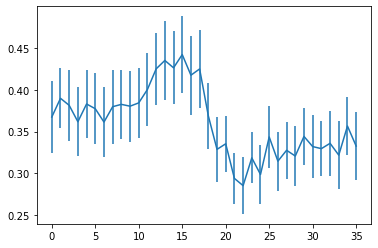

In [113]:
# plot mean+/- CI
CI_plot = np.array(CIs.T)
CI_plot[0,:] = mean_values - CI_plot[0,:] # -
CI_plot[1,:] = CI_plot[1,:] - mean_values # +
errorbar(range(len(mean_values)),mean_values,CI_plot) # - then +

In [114]:
CI_plot

array([[0.0430733 , 0.03590568, 0.04230447, 0.04132363, 0.04102476,
        0.0424575 , 0.04170811, 0.0439816 , 0.04131689, 0.04244584,
        0.04154627, 0.04312887, 0.04266432, 0.04761731, 0.04344561,
        0.04580109, 0.04728243, 0.04663376, 0.03959895, 0.03902533,
        0.03376515, 0.03088836, 0.03377371, 0.03029521, 0.03534042,
        0.03751954, 0.03522358, 0.0342484 , 0.03629798, 0.03374092,
        0.03726718, 0.03267929, 0.03917125, 0.04054534, 0.03517268,
        0.04106272],
       [0.0430733 , 0.03590568, 0.04230447, 0.04132363, 0.04102476,
        0.0424575 , 0.04170811, 0.0439816 , 0.04131689, 0.04244584,
        0.04154627, 0.04312887, 0.04266432, 0.04761731, 0.04344561,
        0.04580109, 0.04728243, 0.04663376, 0.03959895, 0.03902533,
        0.03376515, 0.03088836, 0.03377371, 0.03029521, 0.03534042,
        0.03751954, 0.03522358, 0.0342484 , 0.03629798, 0.03374092,
        0.03726718, 0.03267929, 0.03917125, 0.04054534, 0.03517268,
        0.04106272]])

In [191]:
# find significant bins via ME model
import statsmodels.formula.api as smf
vc = {'session':'0+session'}
sig_bin_model = smf.mixedlm("ripple_rates ~ bin", bin_df, groups="subject", vc_formula=vc)
bin_model = sig_bin_model.fit(reml=False, method='nm')
bin_model.summary()

# # making sure these are the same
# sig_bin_model2 = smf.mixedlm("ripple_rates ~ bin", bin_df, groups="session")
# bin_model2 = sig_bin_model2.fit(reml=False, method='nm')
# bin_model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: ripple_rates 
No. Observations: 919584  Method:             ML           
No. Groups:       116     Scale:              3.8979       
Min. group size:  324     Likelihood:         -1930525.2769
Max. group size:  53244   Converged:          Yes          
Mean group size:  7927.4                                   
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.362     0.018  20.647  0.000   0.327   0.396
bin[T.11]    -0.004     0.017  -0.247  0.805  -0.039   0.030
bin[T.12]    -0.013     0.017  -0.762  0.446  -0.048   0.021
bin[T.13]    -0.024     0.017  -1.389  0.165  -0.059   0.010
bin[T.14]     0.004     0.017   0.202  0.840  -0.031   0.038
bin[T.15]     0.008     0.017   0.471  0.638  -0.026   0.042
bin[T.16]    -0.012     0.017  -0.672  0.501  -0.046   0.022
bin[T.17]     0.008     0.017   0.471  0.638  -0.026   0.042
bin[T.18]     0.013     0.017   0.740  0.460  -0.021   0.047
bin[T.19]     0.005     0.017   0.291  0.771  -0.029   0.039
bin[T.20]     0.011     0.017   0.605  0.545  -0.024   0.045
bin[T.21]     0.030     0.017   1.726  0.084  -0.004   0.064
bin[T.22]     0.050     0.017   2.868  0.004   0.016   0.084
bin[T.23]     0.069     0.017   3.966  0.000   0.035   0.104
bin[T.24]     0.058     0.017   3.294  0.001   0.023   0.092
bin[T.25]     0.065     0.017   3.720  0.000   0.031   0.099
bin[T.26]     0.056     0.017   3.182  0.001   0.021   0.090
bin[T.27]     0.060     0.017   3.429  0.001   0.026   0.094
bin[T.28]    -0.007     0.017  -0.381  0.703  -0.041   0.028
bin[T.29]    -0.064     0.017  -3.653  0.000  -0.098  -0.030
bin[T.30]    -0.060     0.017  -3.406  0.001  -0.094  -0.025
bin[T.31]    -0.099     0.017  -5.647  0.000  -0.133  -0.064
bin[T.32]    -0.101     0.017  -5.804  0.000  -0.136  -0.067
bin[T.33]    -0.077     0.017  -4.415  0.000  -0.111  -0.043
bin[T.34]    -0.092     0.017  -5.289  0.000  -0.127  -0.058
bin[T.35]    -0.047     0.017  -2.689  0.007  -0.081  -0.013
bin[T.36]    -0.072     0.017  -4.146  0.000  -0.107  -0.038
bin[T.37]    -0.056     0.017  -3.205  0.001  -0.090  -0.022
bin[T.38]    -0.061     0.017  -3.473  0.001  -0.095  -0.026
bin[T.39]    -0.040     0.017  -2.286  0.022  -0.074  -0.006
bin[T.40]    -0.047     0.017  -2.667  0.008  -0.081  -0.012
bin[T.41]    -0.054     0.017  -3.115  0.002  -0.089  -0.020
bin[T.42]    -0.050     0.017  -2.846  0.004  -0.084  -0.015
bin[T.43]    -0.034     0.017  -1.972  0.049  -0.069  -0.000
bin[T.44]    -0.025     0.017  -1.434  0.152  -0.059   0.009
bin[T.45]    -0.037     0.017  -2.129  0.033  -0.071  -0.003
session Var   0.017     0.001                               
===========================================================

"""

# compare two bins for stats

In [16]:
bins_to_compare = [10,15]

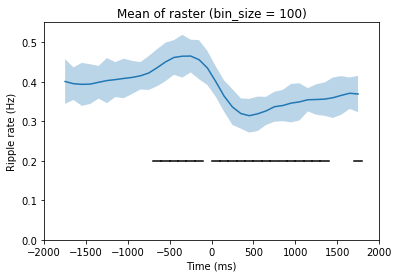

In [233]:
%autoreload
bin_size = 100 # ms
psth_start = -2000
psth_end = 2000

smoothing_triangle = 5 # triangular smoothing window width
pad = 2 #int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

start_array.shape
true_PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
plot(remaining_bin_centers,true_PSTH[pad:-pad]) # throw away edge bins which have some weird values
fill_between(remaining_bin_centers, (true_PSTH)[pad:-pad]+CI_plot, (true_PSTH-CI_plot)[pad:-pad], alpha = 0.3)

# signify significnat bins
for sig in remaining_bin_centers[survives_FDR]:
    plot( range(int(sig-bin_size/2),int(sig+bin_size/2)) , 0.2*np.ones(int(bin_size)), color=(0,0,0))
grand_mean = np.mean(true_PSTH,0)
ax = plt.gca()
ylim = 0.55
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start,psth_end)
xlabel('Time (ms)')
ylabel('Ripple rate (Hz)')
title('Mean of raster (bin_size = '+str(bin_size)+')');

In [231]:
remaining_bin_centers

array([-1750., -1650., -1550., -1450., -1350., -1250., -1150., -1050.,
        -950.,  -850.,  -750.,  -650.,  -550.,  -450.,  -350.,  -250.,
        -150.,   -50.,    50.,   150.,   250.,   350.,   450.,   550.,
         650.,   750.,   850.,   950.,  1050.,  1150.,  1250.,  1350.,
        1450.,  1550.,  1650.,  1750.])

In [197]:
# thish was to do pairwise stats:
# now, to set up ME regression, append each time_bin to bottom and duplicate
binned_start_array.shape
bin_label = []
session_name = []
subject_name = []
ripple_rates = []
for time_bin in range(10,10+np.shape(binned_start_array)[1]): # adding 10 just so all values have 2 digits (easier for sort later)
    session_name.extend(session_name_array)
    subject_name.extend(subject_name_array)
    bin_label.extend(np.tile(str(time_bin),start_array.shape[0]))
    ripple_rates.extend(binned_start_array[:,time_bin-10]) # account for +10
bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,
                           'bin':bin_label,'ripple_rates':ripple_rates})

# this was to do FDR correction:
from mne.stats import fdr_correction,bonferroni_correction
# find significant bins
bin_pvalues = bin_model.pvalues[1:]
survives_FDR, pval_cor = fdr_correction(bin_pvalues, 0.05)  #Benjamini-Hochberg with a 0.05 threshold. 
remaining_bin_centers = bin_centers[pad:-pad]
remaining_bin_centers
survives_FDR

# Paul instructions to get sessions nested in subjects:

#basically I set up a dataframe
#with Subject Code, Session, List #, Stim ON/OFF, and List-level recall

import statsmodels.api as sm
#.... (set up dataframe here) ....
vcf= {'Session':'0+C(Session)'}
model = sm.MixedLM.from_formula('Recall ~ C(Stim_YN)+List', groups='Subject', data=TBI_model_df, vc_formula=vcf) 
result = model.fit(reml = False, method = 'nm')

2

NameError: name 'TBI_model_df' is not defined

I would either do one model per time bin and then FDR correct the p-values or I would have one fixed effect of time. time can either be a continuous variables (you hypothesize that your dep variable, eg power, monotonically goes up or down over time) or it can be categorical if you don't want to make that assumption

If you model time as a categorical factor with X levels, and it's significant (the omnibus effect), you could then compare the different levels?

yeah then you do what nick said. categorical effect of time and look at the contrast

in python you do "DV ~ C(time)" (edited) 

the c makes time a categorical variable

you can also specify the coding for said variable (edited) 

e.g. C(time, Treatment) makes it treatment coded

https://www.statsmodels.org/devel/contrasts.html

that way you determine which contrasts it spits out, which is relevant for the comparisons among bins that you are interested in

# get a list of all the separate start_arrays for each subject so can create within-subjects confidence intervals
# note: we decided not to use this since doesn't make sense for non-blocked data

In [62]:
temp_sub_array = []
previous_sub = []
separate_subject_start_arrays = []
# get arrays of predictors for each trial so can set up ME model
subject_name_array = []
session_name_array = []

separate_sub_trial_number = []
trial_ct = 0
for ct,subject in enumerate(sub_names):
    current_range = range(int(trial_ct),int(trial_ct+trial_nums[ct]))
    if ct == len(sub_names)-1: # if last sub
        if previous_sub == subject: # then stack last ripplearray and append it
            temp_sub_array = superVstack(temp_sub_array,start_array[current_range])
            separate_subject_start_arrays.append(temp_sub_array)
        else:
            separate_subject_start_arrays.append(temp_sub_array) # append previous one
            temp_sub_array = start_array[current_range] # get new,last one
            separate_subject_start_arrays.append(temp_sub_array) # append this last one too
    elif previous_sub == subject or ct == 0: # keep appending if same sub
        temp_sub_array = superVstack(temp_sub_array,start_array[current_range])
    else: # if this is a new sub, append last one to the saved list and restart temp_array
        separate_subject_start_arrays.append(temp_sub_array)
        temp_sub_array = start_array[current_range] # for this new sub, append first range
    previous_sub = subject
    
    trials_this_loop = int(trial_nums[ct])
    trial_ct = trial_ct + trials_this_loop 
    # update each array with subjects, sessions, and other prdictors
    subject_name_array.extend(np.tile(subject,trials_this_loop))
    session_name_array.extend(np.tile(sub_sess_names[ct],trials_this_loop))
    
# get the PSTH for each of these separate subjects and subtract the mean of this PSTH to remove between-subject variance
corrected_sub_PSTHs = []
for sub_start_array in separate_subject_start_arrays:
    sub_PSTH,_ = fullPSTH(sub_start_array,bin_size,1,sr,psth_start)
    sub_PSTH = sub_PSTH-np.mean(sub_PSTH)+grand_mean
    corrected_sub_PSTHs = superVstack(corrected_sub_PSTHs,sub_PSTH)
# calculate confidence intervals
num_subs,num_bins = corrected_sub_PSTHs.shape
t_value = stats.t.ppf(1-0.025, num_subs-1)
mean_within_subs = np.mean(corrected_sub_PSTHs,0)
CI_within = t_value * np.std(corrected_sub_PSTHs,0) / np.sqrt(num_subs) * np.sqrt(num_bins/(num_bins-1))

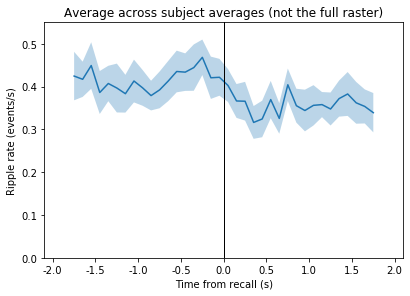

In [33]:
# make a PSTH based on start times of SWRs
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)

## if want to plot the within-subjects mean instead! (averages across subjects instead of binning whole array)
PSTH = mean_within_subs 
# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr[pad:-pad],PSTH[pad:-pad])
fill_between(xr[pad:-pad], (PSTH+CI_within)[pad:-pad], (PSTH-CI_within)[pad:-pad], alpha = 0.3)
# plot(xr[pad:-pad],mean_within_subs[pad:-pad]) # the mean between subjects # if want to plot within-subjects mean over the top

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ylim = 0.55
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
title('Average across subject averages (not the full raster)');